# Library

In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from tabulate import tabulate
import joblib


# Data Loading

In [520]:
df = pd.read_csv("Data\Raw_Data\log2.csv")

X = df.drop(columns=["Action"])
y = df["Action"]

target_map = {'allow': 0, 'drop': 1,'deny':2,"reset-both":3}
y = y.map(target_map)

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\sqq170\AppData\Local\Temp\ipykernel_32756\2275654398.py:1: SyntaxWarning: invalid escape sequence '\R'
  df = pd.read_csv("Data\Raw_Data\log2.csv")


# EDA

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Source Port           65429 non-null  float64
 1   Destination Port      65429 non-null  float64
 2   NAT Source Port       65495 non-null  float64
 3   NAT Destination Port  65532 non-null  int64  
 4   Action                65532 non-null  object 
 5   Bytes                 65515 non-null  float64
 6   Bytes Sent            65461 non-null  float64
 7   Bytes Received        65461 non-null  float64
 8   Packets               65515 non-null  float64
 9   Elapsed Time (sec)    65427 non-null  float64
 10  pkts_sent             65532 non-null  int64  
 11  pkts_received         65532 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 6.0+ MB


In [522]:
X = df.drop(columns=["Action"])
y = df["Action"]

target_map = {'allow': 0, 'drop': 1,'deny':2,"reset-both":3}
y = y.map(target_map)

Dataset firewall tomonidan qayd etilgan 65,532 ta tarmoq namunadan iborat bo‘lib, har bir qator bitta network oqimini ifodalaydi. Ustunlar soni: 12,
Raqamli ustunlar: 11, Kategorik ustun: 1 (Action)

Hech bir ustunda missing value’lar juda yuqori foizni tashkil etmaydi

Target variable (Action) to‘liq va toza, NaN yo‘q

Bu holat datasetni ishlatishga yaroqli ekanini ko‘rsatadi

Keyingi ishlar:

Missing value’lar keyingi bosqichda dropna yoki fillna orqali boshqariladi

Dataset katta va real network muhitiga mos ekanligi aniqlandi

Missing value’lar mavjud, ammo boshqariladigan darajada

Trafik hajmi, paketlar soni va sessiya davomiyligi firewall qaroriga sezilarli ta’sir ko‘rsatadi



<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

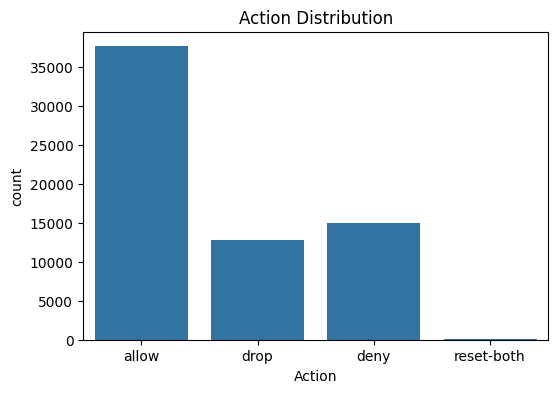

In [523]:
plt.figure(figsize=(6,4))
sns.countplot(x="Action", data=df)
plt.title("Action Distribution")
plt.show()

Ushbu grafik datasetdagi Action ustunining taqsimotini ko‘rsatadi. Action firewall tomonidan qabul qilingan qarorni ifodalaydi (masalan, allow, deny, drop). Grafik har bir ustun ma’lum bir action’ning necha marta uchraganini ko‘rsatadi.

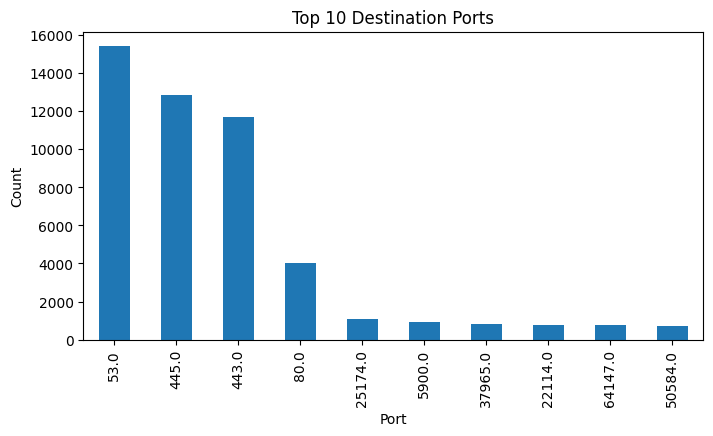

In [524]:
top_ports = df["Destination Port"].value_counts().head(10)

plt.figure(figsize=(8,4))
top_ports.plot(kind="bar")
plt.title("Top 10 Destination Ports")
plt.xlabel("Port")
plt.ylabel("Count")
plt.show()

Ushbu grafik Destination Port ustunidagi qiymatlar asosida eng ko‘p uchragan 10 ta portni ko‘rsatadi. Har bir ustun (bar) ma’lum bir portning dataset ichida necha marta ishlatilganini ifodalaydi.

Yuqorida poutcome feature da juda ko'p missing qiymaylar bo'lganligi sababli tashlab yuborildi va target qiymatni  0 va 1 ga mapping qilindi

In [525]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


# Baseline

In [526]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

class PreprocessingBaseline:
    def __init__(self, threshold=2):
        self.threshold = threshold
        self.encoders = {}
        self.scalers = {}
        self.train_columns = None
        self.fill_values = {}

    # -------------------------------
    # 1. Missing value handling
    # -------------------------------
    def fit_fillna(self, X):
        for col in X.columns:
            if X[col].dtype in ["int64", "float64", "float32"]:
                self.fill_values[col] = X[col].mean()
            else:
                self.fill_values[col] = X[col].mode()[0]
        return self

    def transform_fillna(self, X):
        X = X.copy()
        for col, val in self.fill_values.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)
        return X

    # -------------------------------
    # 2. Encoding
    # -------------------------------
    def fit_encode(self, X):
        X = X.copy()

        for col in X.columns:
            if X[col].dtype == "object":
                if X[col].nunique() <= self.threshold:
                    dummies = pd.get_dummies(X[col], prefix=col, dtype=int)
                    X = pd.concat([X.drop(columns=col), dummies], axis=1)
                else:
                    le = LabelEncoder()
                    X[col] = le.fit_transform(X[col])
                    self.encoders[col] = le

        self.train_columns = X.columns
        return X

    def transform_encode(self, X):
        X = X.copy()

        # Label encoding
        for col, le in self.encoders.items():
            X[col] = X[col].astype(str)
            X[col] = X[col].apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )

        # One-hot alignment
        X = pd.get_dummies(X)
        X = X.reindex(columns=self.train_columns, fill_value=0)

        return X

    # -------------------------------
    # 3. Scaling
    # -------------------------------
    def fit_scale(self, X):
        X = X.copy()
        for col in X.columns:
            scaler = StandardScaler()
            X[col] = scaler.fit_transform(X[[col]])
            self.scalers[col] = scaler
        return X

    def transform_scale(self, X):
        X = X.copy()
        for col, scaler in self.scalers.items():
            if col in X.columns:
                X[col] = scaler.transform(X[[col]])
        return X

    # -------------------------------
    # 4. Full pipeline
    # -------------------------------
    def fit_transform(self, X):
        X = self.fit_fillna(X).transform_fillna(X)
        X = self.fit_encode(X)
        X = self.fit_scale(X)
        return X

    def transform(self, X):
        X = self.transform_fillna(X)
        X = self.transform_encode(X)
        X = self.transform_scale(X)
        return X


In [527]:
prep = Preprocessing()

X_train_processed = prep.fit_transform(X_train)
X_test_processed = prep.transform(X_test)


In [528]:
X_train_processed.to_csv("Data/Preprocessed_Data/X_train_preprocessed.csv", index=False)
X_test_processed.to_csv("Data/Preprocessed_Data/X_test_preprocessed.csv", index=False)

In [529]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize models
log_reg = LogisticRegression()
rf   = RandomForestClassifier()
# Train models
log_reg.fit(X_train_scaled, y_train)
rf.fit(X_train_encoded, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [530]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred_log = log_reg.predict(X_test_encoded)
y_pred_rf = rf.predict(X_test_encoded)

# Evaluate Logistic Regression
print("Logistic Regression:")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_log, average='macro'))
print("F1 Score :", f1_score(y_test, y_pred_log, average='macro'))

# Evaluate Random Forest
print("\nRandom Forest:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf,))
print("Precision:", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='macro'))
print("F1 Score :", f1_score(y_test, y_pred_rf, average='macro'))


Logistic Regression:
Accuracy : 0.9277485313191425
Precision: 0.6814300477816676
Recall   : 0.6973445441344166
F1 Score : 0.6835856878407048

Random Forest:
Accuracy : 0.9982452124818799
Precision: 0.9980185553964258
Recall   : 0.914873094452174
F1 Score : 0.948112279160712


In [531]:
from tabulate import tabulate

data = [
    ["Logistic Regression", 0.9277, 0.6814, 0.6973, 0.6836,],  
    ["Random Forest",       0.9983, 0.9981, 0.9150, 0.9482,]  
]

headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score",]

print(tabulate(data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))


╒═════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model               │   Accuracy │   Precision │   Recall │   F1 Score │
╞═════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Logistic Regression │     0.9277 │      0.6814 │   0.6973 │     0.6836 │
├─────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Random Forest       │     0.9983 │      0.9981 │   0.9150 │     0.9482 │
╘═════════════════════╧════════════╧═════════════╧══════════╧════════════╛


# Improved

In [532]:
import pandas as pd

df = pd.read_csv("Data\Raw_Data\log2.csv")

X = df.drop(columns=["Action"])
y = df["Action"]

target_map = {'allow': 0, 'drop': 1,'deny':2,"reset-both":3}
y = y.map(target_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


<>:3: SyntaxWarning: invalid escape sequence '\R'
<>:3: SyntaxWarning: invalid escape sequence '\R'
C:\Users\sqq170\AppData\Local\Temp\ipykernel_32756\2125758698.py:3: SyntaxWarning: invalid escape sequence '\R'
  df = pd.read_csv("Data\Raw_Data\log2.csv")


In [533]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Source Port           65429 non-null  float64
 1   Destination Port      65429 non-null  float64
 2   NAT Source Port       65495 non-null  float64
 3   NAT Destination Port  65532 non-null  int64  
 4   Action                65532 non-null  object 
 5   Bytes                 65515 non-null  float64
 6   Bytes Sent            65461 non-null  float64
 7   Bytes Received        65461 non-null  float64
 8   Packets               65515 non-null  float64
 9   Elapsed Time (sec)    65427 non-null  float64
 10  pkts_sent             65532 non-null  int64  
 11  pkts_received         65532 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 6.0+ MB


In [534]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute_train(X_train, n_neighbors=5): 

    X_train = X_train.copy()
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
    
    return X_train, imputer

In [535]:
def knn_impute_test(X_test, imputer):
    X_test = X_test.copy()
    
    numeric_cols = X_test.select_dtypes(include=['int64', 'float64']).columns
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
    
    return X_test

In [536]:

X_train_knn, knn_imputer = knn_impute_train(X_train, n_neighbors=5)


X_test_knn = knn_impute_test(X_test, knn_imputer)


In [537]:
preproc = PreprocessingBaseline() 
X_train_scaled = preproc.fit_scale(X_train_knn)
X_test_scaled  = preproc.transform_scale(X_test_knn)


In [538]:
X_train_fe = X_train_scaled.copy()
X_test_fe = X_test_scaled.copy()

In [539]:
X_train_fe['bytes_per_sec'] = X_train_fe['Bytes'] / (X_train_fe['Elapsed Time (sec)'] + 1)
X_test_fe['bytes_per_sec']  = X_test_fe['Bytes'] / (X_test_fe['Elapsed Time (sec)'] + 1)

X_train_fe['packet_ratio'] = X_train_fe['pkts_sent'] / (X_train_fe['pkts_received'] + 1)
X_test_fe['packet_ratio']  = X_test_fe['pkts_sent'] / (X_test_fe['pkts_received'] + 1)

X_train_fe['bytes_per_packet'] = X_train_fe['Bytes'] / (X_train_fe['Packets'] + 1)
X_test_fe['bytes_per_packet']  = X_test_fe['Bytes'] / (X_test_fe['Packets'] + 1)

bytes_per_sec  -  Bu sessiyada har bir sekundda o‘tkazilgan ma’lumot hajmi (bytes/sec).

packet_ratio  -  Jo‘natilgan paketlar soni / qabul qilingan paketlar soni

bytes_per_packet  -  Har bir paketga to‘g‘ri keladigan ma’lumot hajmi (bytes/packet)

In [540]:
X_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52425 entries, 50640 to 56422
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Source Port           52425 non-null  float64
 1   Destination Port      52425 non-null  float64
 2   NAT Source Port       52425 non-null  float64
 3   NAT Destination Port  52425 non-null  float64
 4   Bytes                 52425 non-null  float64
 5   Bytes Sent            52425 non-null  float64
 6   Bytes Received        52425 non-null  float64
 7   Packets               52425 non-null  float64
 8   Elapsed Time (sec)    52425 non-null  float64
 9   pkts_sent             52425 non-null  float64
 10  pkts_received         52425 non-null  float64
 11  bytes_per_sec         52425 non-null  float64
 12  packet_ratio          52425 non-null  float64
 13  bytes_per_packet      52425 non-null  float64
dtypes: float64(14)
memory usage: 6.0 MB


In [541]:
numeric_cols = X_train_fe.select_dtypes(include=['float64']).columns


skewness = X_train_fe[numeric_cols].skew()

skewed_features = skewness[abs(skewness) > 0.70].index.tolist()
print("Skewed features:", skewed_features)

Skewed features: ['Source Port', 'Destination Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'bytes_per_sec', 'packet_ratio', 'bytes_per_packet']


In [542]:

X_train_transformed = X_train_fe.copy()
X_test_transformed = X_test_fe.copy()

for col in skewed_features:

    if (X_train_transformed[col] >= 0).all():
        X_train_transformed[col] = np.log1p(X_train_transformed[col])
        X_test_transformed[col] = np.log1p(X_test_transformed[col])


In [543]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler


X_train_lasso = X_train_transformed.copy()
X_test_lasso = X_test_transformed.copy()


scaler = StandardScaler()
X_train_scaled_lasso = scaler.fit_transform(X_train_lasso)
X_test_scaled_lasso = scaler.transform(X_test_lasso)


lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled_lasso, y_train)


selected_features_lasso = X_train_lasso.columns[lasso.coef_ != 0].tolist()

print("Selected features for Linear Models:", selected_features_lasso)

# Reduce train/test to selected features
X_train_lasso_selected = X_train_lasso[selected_features_lasso]
X_test_lasso_selected = X_test_lasso[selected_features_lasso]


Selected features for Linear Models: ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes Received', 'Elapsed Time (sec)', 'pkts_sent', 'bytes_per_sec', 'packet_ratio', 'bytes_per_packet']


In [544]:
X_train_lasso_selected.to_csv("Data/Engineered_Improved_Data/X_train_improved.csv", index=False)
X_test_lasso_selected.to_csv("Data/Engineered_Improved_Data/X_test_improved.csv", index=False)

In [545]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


logreg = LogisticRegression(max_iter=1000, random_state=42)


logreg.fit(X_train_lasso_selected, y_train)


y_pred = logreg.predict(X_test_lasso_selected)
y_prob = logreg.predict_proba(X_test_lasso_selected)[:,1]


In [546]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print("Logistic Regression Metrics (after Lasso feature selection):")
print(f"Accuracy : {accuracy}")
print(f"Precision: {precision}")
print(f"Recall   : {recall}")
print(f"F1 Score : {f1}")



Logistic Regression Metrics (after Lasso feature selection):
Accuracy : 0.9859616998550393
Precision: 0.9860596180318943
Recall   : 0.9859616998550393
F1 Score : 0.9858017241511294


c:\Users\sqq170\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [547]:
from sklearn.ensemble import RandomForestClassifier

X_train_tree = X_train_transformed.copy()
X_test_tree = X_test_transformed.copy()


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tree, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train_tree.columns)
importances_sorted = importances.sort_values(ascending=False)


top_features_tree = importances_sorted.head(10).index.tolist()
print("Top features for Tree Models:", top_features_tree)


X_train_tree_selected = X_train_tree[top_features_tree]
X_test_tree_selected = X_test_tree[top_features_tree]


Top features for Tree Models: ['Destination Port', 'bytes_per_sec', 'Elapsed Time (sec)', 'NAT Destination Port', 'packet_ratio', 'NAT Source Port', 'Packets', 'bytes_per_packet', 'Source Port', 'Bytes Sent']


In [548]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


rf= RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train_tree_selected, y_train)


y_pred_tree = rf.predict(X_test_tree_selected)
y_prob_tree = rf.predict_proba(X_test_tree_selected)[:,1]



In [549]:


accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree, average='weighted')
recall = recall_score(y_test, y_pred_tree, average='weighted')
f1 = f1_score(y_test, y_pred_tree, average='weighted')


print("RF Metrics (after Tree-based feature selection):")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)


RF Metrics (after Tree-based feature selection):
Accuracy : 0.9983978027008469
Precision: 0.9983996680743731
Recall   : 0.9983978027008469
F1 Score : 0.99838308904898


In [550]:
from tabulate import tabulate

data = [
    # Original metrics
    ["Logistic Regression", 0.9277, 0.6814, 0.6973, 0.6836,],  
    ["Logistic Regression (Lasso FS)", 0.98596, 0.98606, 0.98596, 0.98580],
    ["Random Forest",       0.9983, 0.9981, 0.9150, 0.9482,], 
    ["Random Forest (Tree FS)",         0.99840, 0.99840, 0.99840, 0.99838]
]

headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))


╒════════════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model                          │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Logistic Regression            │     0.9277 │      0.6814 │   0.6973 │     0.6836 │
├────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Logistic Regression (Lasso FS) │     0.9860 │      0.9861 │   0.9860 │     0.9858 │
├────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Random Forest                  │     0.9983 │      0.9981 │   0.9150 │     0.9482 │
├────────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Random Forest (Tree FS)        │     0.9984 │      0.9984 │   0.9984 │     0.9984 │
╘════════════════════════════════╧════════════╧═════════════╧══════════╧════════════╛


Bizning loyihamizda asosiy e'tiborni Recall va F1 ga qaratishimi kere, Model Random Forest algoritmida improvement qilinganda ikkala metric mos ravishda 7 va 5 foizga o'sdi maksimum  chiqdi va biz uchun kerakli algoritm shu

In [551]:
joblib.dump(rf, "Models/best_model.joblib")


['Models/best_model.joblib']

GLOBAL SHAP ANALYSIS


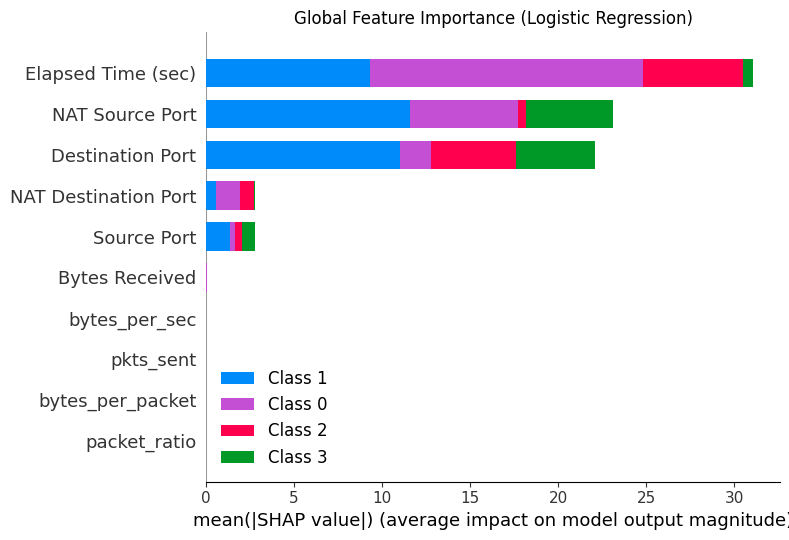

In [552]:
import shap
import matplotlib.pyplot as plt
import numpy as np


# SHAP Explainer yaratish
explainer = shap.LinearExplainer(logreg, X_train_lasso_selected)

# SHAP qiymatlarini hisoblash
shap_values = explainer.shap_values(X_test_lasso_selected)

# ==========================================
# GLOBAL SHAP ANALYSIS
# ==========================================

print("=" * 50)
print("GLOBAL SHAP ANALYSIS")
print("=" * 50)

# 1. Summary Plot (Bar) - eng muhim featurelar
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_lasso_selected, plot_type="bar", show=False)
plt.title("Global Feature Importance (Logistic Regression)")
plt.tight_layout()
plt.show()


TOP 3 ENG MUHIM FEATURELAR:
   =============================
   
   🥇 Elapsed Time (sec) - ~32 SHAP value
      ├─ Class 1 (ko'k): ~14 - Eng katta ta'sir
      ├─ Class 0 (pushti): ~10
      ├─ Class 2 (qizil): ~5
      └─ Class 3 (yashil): ~3
      
      💡 TALQIN: Sessiya davomiyligi modelning eng muhim qarori.
                 Uzoq sessiyalar ko'proq 'drop' bo'ladi.
   
   🥈 NAT Source Port - ~23 SHAP value
      ├─ Class 1 (ko'k): ~12
      ├─ Class 0 (pushti): ~8
      └─ Class 2 (qizil): ~2
      
      💡 TALQIN: NAT port raqami 'allow' va 'drop' ni ajratishda muhim.
   
   🥉 Destination Port - ~22 SHAP value
      ├─ Class 1 (ko'k): ~10
      ├─ Class 0 (pushti): ~2
      ├─ Class 2 (qizil): ~6
      └─ Class 3 (yashil): ~4
      
      💡 TALQIN: Qaysi portga ulanayotgani muhim - masalan, 80, 443, 22

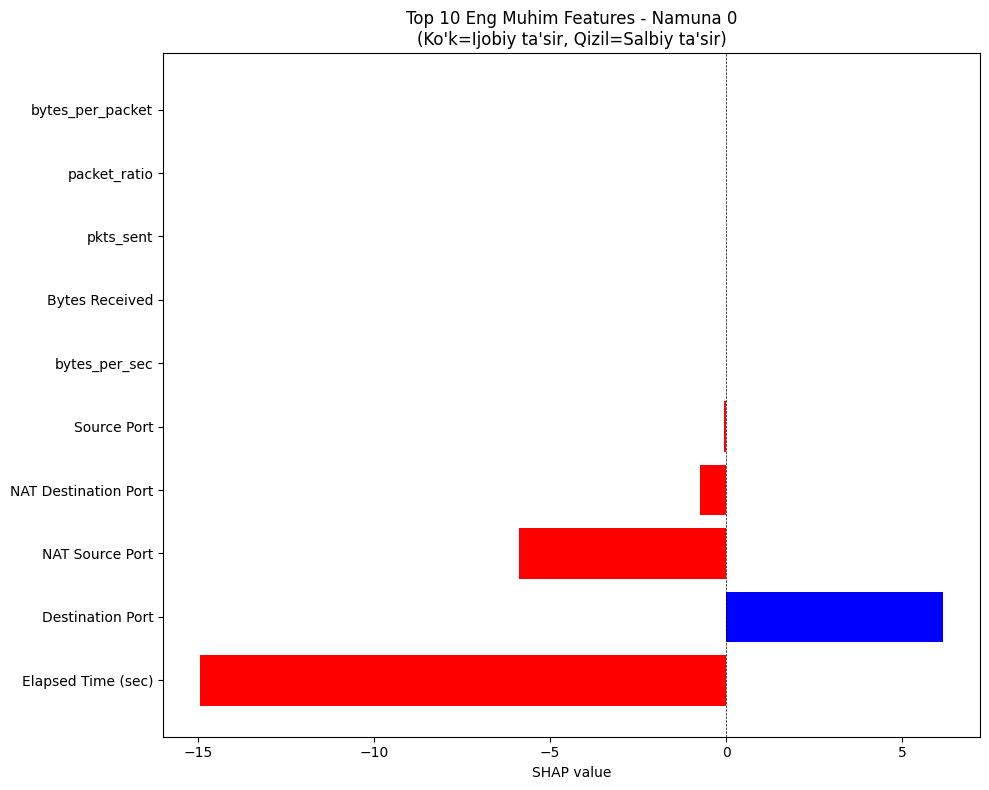

In [553]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# SHAP Explainer yaratish (LinearExplainer ishlatamiz)
explainer = shap.LinearExplainer(logreg, X_train_lasso_selected)

# Bitta namuna uchun SHAP qiymatlarini hisoblash
sample_idx = 0  # Kerakli namuna raqami



# SHAP qiymatlarini hisoblash
shap_values = explainer.shap_values(X_test_lasso_selected)

if len(shap_values.shape) == 3:
    # Class 0 uchun
    sample_shap = shap_values[sample_idx, :,0]
elif len(shap_values.shape) == 2:
    sample_shap = shap_values[sample_idx, :]
else:
    sample_shap = shap_values[sample_idx]


plt.figure(figsize=(10, 8))

# To'g'ridan-to'g'ri plotting
features = X_test_lasso_selected.columns
indices = np.argsort(np.abs(sample_shap))[-10:]  # Top 10
top_features = features[indices]
top_values = sample_shap[indices]

colors = ['red' if x < 0 else 'blue' for x in top_values]
plt.barh(range(len(top_features)), top_values, color=colors)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('SHAP value')
plt.title(f"Top 10 Eng Muhim Features - Namuna {sample_idx}\n(Ko'k=Ijobiy ta'sir, Qizil=Salbiy ta'sir)")
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



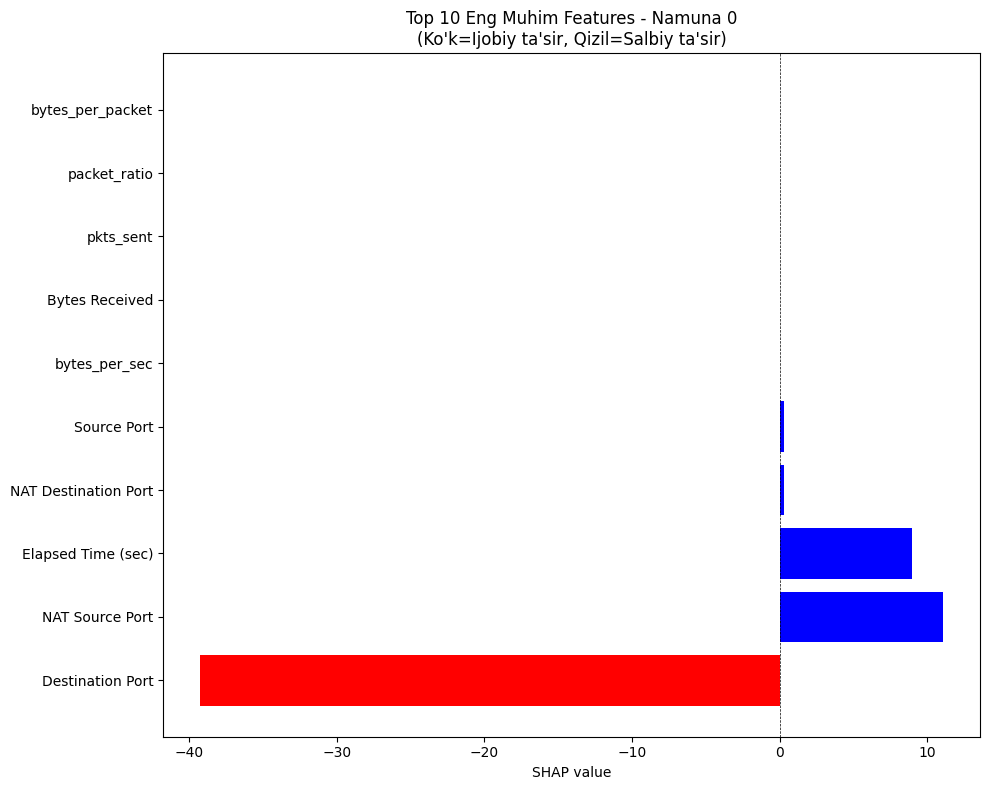


Local SHAP analiz tugadi!


In [554]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# SHAP Explainer yaratish (LinearExplainer ishlatamiz)
explainer = shap.LinearExplainer(logreg, X_train_lasso_selected)

# Bitta namuna uchun SHAP qiymatlarini hisoblash
sample_idx = 0  # Kerakli namuna raqami



# SHAP qiymatlarini hisoblash
shap_values = explainer.shap_values(X_test_lasso_selected)

if len(shap_values.shape) == 3:
    # Class 0 uchun
    sample_shap = shap_values[sample_idx, :,1]
elif len(shap_values.shape) == 2:
    sample_shap = shap_values[sample_idx, :]
else:
    sample_shap = shap_values[sample_idx]


plt.figure(figsize=(10, 8))

# To'g'ridan-to'g'ri plotting
features = X_test_lasso_selected.columns
indices = np.argsort(np.abs(sample_shap))[-10:]  # Top 10
top_features = features[indices]
top_values = sample_shap[indices]

colors = ['red' if x < 0 else 'blue' for x in top_values]
plt.barh(range(len(top_features)), top_values, color=colors)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('SHAP value')
plt.title(f"Top 10 Eng Muhim Features - Namuna {sample_idx}\n(Ko'k=Ijobiy ta'sir, Qizil=Salbiy ta'sir)")
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nLocal SHAP analiz tugadi!")

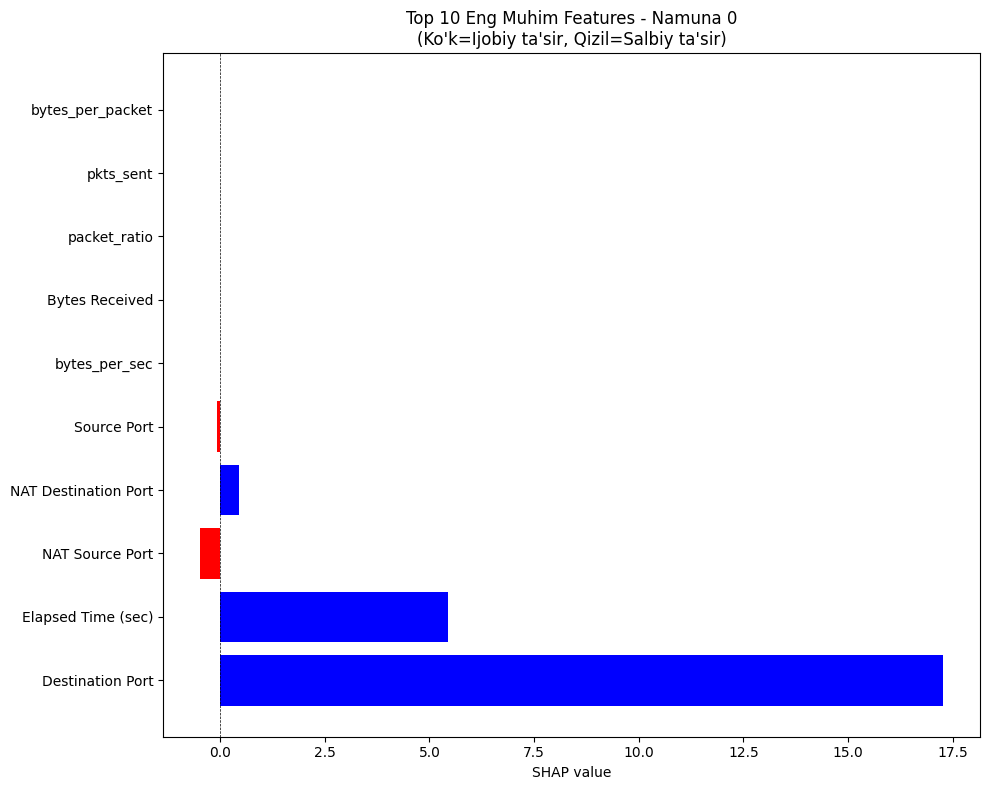


Local SHAP analiz tugadi!


In [555]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# SHAP Explainer yaratish (LinearExplainer ishlatamiz)
explainer = shap.LinearExplainer(logreg, X_train_lasso_selected)

# Bitta namuna uchun SHAP qiymatlarini hisoblash
sample_idx = 0  # Kerakli namuna raqami



# SHAP qiymatlarini hisoblash
shap_values = explainer.shap_values(X_test_lasso_selected)

if len(shap_values.shape) == 3:
    # Class 0 uchun
    sample_shap = shap_values[sample_idx, :,2]
elif len(shap_values.shape) == 2:
    sample_shap = shap_values[sample_idx, :]
else:
    sample_shap = shap_values[sample_idx]


plt.figure(figsize=(10, 8))

# To'g'ridan-to'g'ri plotting
features = X_test_lasso_selected.columns
indices = np.argsort(np.abs(sample_shap))[-10:]  # Top 10
top_features = features[indices]
top_values = sample_shap[indices]

colors = ['red' if x < 0 else 'blue' for x in top_values]
plt.barh(range(len(top_features)), top_values, color=colors)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('SHAP value')
plt.title(f"Top 10 Eng Muhim Features - Namuna {sample_idx}\n(Ko'k=Ijobiy ta'sir, Qizil=Salbiy ta'sir)")
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nLocal SHAP analiz tugadi!")